# 🔍 Project Overview
This notebook presents a complete end-to-end optimization and deployment pipeline for a GPT-2-style small language model (SLM), with the goal of achieving efficient inference on resource-constrained environments.

## 📦 Part 1: Load & Profile GPT-2 in FP16 on GPU (NVIDIA T4)
- **Objective**: Load the GPT-2 model with half-precision (FP16) to reduce memory footprint and accelerate inference.

- **Hardware**: NVIDIA T4 GPU (16 GB GDDR6).

- **Tasks**:
    - Load a pretrained GPT-2 model using Hugging Face Transformers.
    - Convert weights to FP16.
    - Measure baseline performance: latency, throughput, VRAM usage.
    - Use torch.profiler to generate flame graphs for bottleneck analysis.
 

### Environment Setup
#### Hardware & Software Requirements


*   GPU: NVIDIA T4 (16 GB GDDR6 VRAM, 320 GB/s bandwidth, 320 Turing Tensor Cores)
*   CPU: 2 vCPUs, 4 GB RAM for final inference stage
*   Python Version: ≥ 3.8
*   Libraries:
    * torch
    * transformers
    * optimum
    * datasets
    * tqdm, matplotlib, and psutil for progress bars, plotting, and memory checks

### Install the libraries

We run `nvidia-smi` to check if GPU is visible and ready to use. We then install the necessary libraries. 

In [1]:
!nvidia-smi

Tue Dec  9 09:56:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.95.05              Driver Version: 580.95.05      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        On  |   00000000:0B:00.0 Off |                  N/A |
|  0%   37C    P8             18W /  400W |    4558MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Logging into Huggingface and Authincating 

In [2]:
import os
from dotenv import load_dotenv
from huggingface_hub import login

# Load environment variables from .env file
load_dotenv()

HF_TOKEN = os.getenv("HF_TOKEN")

if HF_TOKEN:
    login(HF_TOKEN)
    print("Successfully logged in to Hugging Face!")
else:
    print("Token is not set. Please add HF_TOKEN to your .env file.")

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Successfully logged in to Hugging Face!


### Check for GPU

In [3]:
# Check PyTorch GPU availability and VRAM
import torch

print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Version: {torch.version.cuda}")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    total_mem = torch.cuda.get_device_properties(0).total_memory / (1024**3)
    print(f"CUDA Device: {gpu_name}")
    print(f"Total GPU VRAM: {total_mem:.2f} GB")
else:
    raise RuntimeError("CUDA GPU not available! Ensure a T4 is attached.")


PyTorch Version: 2.7.1+cu128
CUDA Version: 12.8
CUDA Device: NVIDIA GeForce RTX 3090
Total GPU VRAM: 23.55 GB


**Expected Output**



```
PyTorch Version: 2.7.1+cu128
CUDA Version: 12.8
CUDA Device: NVIDIA GeForce RTX 3090
Total GPU VRAM: 23.55 GB
```



###  Load GPT2 & Tokenizer

Loads a GPT-2 model and tokenizer in FP16 precision and moves the model to the appropriate device.

    How to implement:
    - Use the `transformers` library to load the tokenizer and model using the provided model ID.
    - Set the model's data type to FP16 (float16).
    - Use `torch` to detect whether a CUDA-compatible GPU is available.
    - Move the model to the selected device (GPU if available, else CPU).
    - Return both the tokenizer and model.

    Args:
        model_id (str): The model name or path to load from Hugging Face (default: "gpt2").

    Returns:
        tuple: A tuple containing the tokenizer and the model.

In [4]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

def load_fp16_model(model_id="gpt2"):
    """
    Loads a GPT-2 model and tokenizer in FP16 precision and moves the model to the appropriate device.

    How to implement:
    - Use the `transformers` library to load the tokenizer and model using the provided model ID.
    - Set the model's data type to FP16 (float16).
    - Use `torch` to detect whether a CUDA-compatible GPU is available.
    - Move the model to the selected device (GPU if available, else CPU).
    - Return both the tokenizer and model.

    Args:
        model_id (str): The model name or path to load from Hugging Face (default: "gpt2").

    Returns:
        tuple: A tuple containing the tokenizer and the model.
    """
    # Load tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained(model_id)
    
    # Set pad token to eos token (GPT-2 doesn't have a pad token by default)
    tokenizer.pad_token = tokenizer.eos_token
    
    # Load model and convert to FP16
    # Use eager attention implementation for compatibility with head pruning
    model = GPT2LMHeadModel.from_pretrained(
        model_id, 
        torch_dtype=torch.float16,
        attn_implementation="eager"
    )
    
    # Set pad_token_id in model config
    model.config.pad_token_id = tokenizer.pad_token_id
    
    # Detect device and move model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    print(f"Loaded model '{model_id}' in FP16 on {device}")
    
    return tokenizer, model

# Load the model and tokenizer
tokenizer, model = load_fp16_model("gpt2")

Loaded model 'gpt2' in FP16 on cuda


#### Lets write a test case to see if we have successfully loaded the model. Run the below cell. **Do not change anything**

In [5]:
def test_load_fp16_model():
    # Simple test prompt
    prompt = "The future of AI is"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Generate text
    with torch.no_grad():
        outputs = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=20,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode output
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    print("\n=== Test Output ===")
    print("Prompt:", prompt)
    print("Generated:", generated_text)

    # Basic correctness checks
    assert model.dtype == torch.float16, "Model is not in FP16"
    assert str(model.device) == str(inputs["input_ids"].device), "Model and input are on different devices"
    assert prompt in generated_text, "Generated text does not include the prompt"
    print("\nTest passed ✅")


test_load_fp16_model()


=== Test Output ===
Prompt: The future of AI is
Generated: The future of AI is uncertain. The future of AI is uncertain.

The future of AI

Test passed ✅


#### You should see an output like this

Loaded model 'gpt2' in FP16 on cuda

=== Test Output ===
Prompt: The future of AI is
Generated: The future of AI is uncertain.

The future of AI is uncertain.

The future

Test passed ✅

### Load WikiTest-2 Dataset

Loads a small subset of the WikiText-2 dataset for training and validation.

    How to implement:
    - Use the `load_dataset` function from the `datasets` library.
    - Load the "wikitext-2-raw-v1" dataset.
    - Specify the split using slice notation strings (e.g., "train[:100]").
    - Return both the training and validation subsets.
    - Optionally, print how many examples are loaded in each split.

    Args:
        train_split (str): Slice of the training data to load.
        valid_split (str): Slice of the validation data to load.

    Returns:
        tuple: A tuple containing the training and validation datasets.

In [6]:
from datasets import load_dataset

def load_wikitext_dataset(train_split="train[:100]", valid_split="validation[:200]"):
    """
    Loads a small subset of the WikiText-2 dataset for training and validation.

    How to implement:
    - Use the `load_dataset` function from the `datasets` library.
    - Load the "wikitext-2-raw-v1" dataset.
    - Specify the split using slice notation strings (e.g., "train[:100]").
    - Return both the training and validation subsets.
    - Optionally, print how many examples are loaded in each split.

    Args:
        train_split (str): Slice of the training data to load.
        valid_split (str): Slice of the validation data to load.

    Returns:
        tuple: A tuple containing the training and validation datasets.
    """
    # Load training and validation subsets
    train_ds = load_dataset("wikitext", "wikitext-2-raw-v1", split=train_split)
    valid_ds = load_dataset("wikitext", "wikitext-2-raw-v1", split=valid_split)
    
    print(f"Loaded {len(train_ds)} training examples")
    print(f"Loaded {len(valid_ds)} validation examples")
    
    return train_ds, valid_ds

# Load the datasets
train_ds, valid_ds = load_wikitext_dataset()

Loaded 100 training examples
Loaded 200 validation examples


#### Lets write a test case to see if we have successfully loaded the dataset. Run the below cell. **Do not change anything**

In [7]:
def test_load_wikitext_dataset():
    print("\n=== Sample Examples ===")
    print("Train[0]:", train_ds[1]['text'])
    print("Valid[0]:", valid_ds[1]['text'])

    # Checks
    assert len(train_ds) == 100, "Train dataset does not contain 100000 samples"
    assert len(valid_ds) == 200, "Validation dataset does not contain 200 samples"
    assert isinstance(train_ds[0]['text'], str), "Train sample is not a string"
    assert isinstance(valid_ds[0]['text'], str), "Validation sample is not a string"

    print("\nTest passed ✅")

test_load_wikitext_dataset()


=== Sample Examples ===
Train[0]:  = Valkyria Chronicles III = 

Valid[0]:  = Homarus gammarus = 


Test passed ✅


#### You should see an output something like this

=== Sample Examples === \
Train[0]:  = Valkyria Chronicles III = 

Valid[0]:  = Homarus gammarus = 


Test passed ✅

### Baseline FP16 GPU Profiling

Measures the average inference latency on GPU in milliseconds per token.

    How to implement:
    1. Set the device using `torch.device`, based on CUDA availability.
    2. Put the model in evaluation mode using `.eval()`.
    3. Tokenize the input prompt and move it to the GPU.
    4. Perform a short warm-up generation (e.g., 10 tokens) to stabilize performance.
    5. Use `time.time()` to measure how long it takes to generate `max_new_tokens`.
    6. Use `torch.cuda.synchronize()` before and after timing to ensure accurate GPU measurements.
    7. Return the average time per token (in ms) by dividing elapsed time by `max_new_tokens`.

    Args:
        model: A causal language model loaded on GPU.
        tokenizer: The tokenizer used for encoding the input prompt.
        prompt (str): The prompt string for text generation.
        max_new_tokens (int): Number of tokens to generate during measurement.

    Returns:
        float: Latency in milliseconds per generated token.

Below this cell, implement `measure_latency_gpu(...)` step by step following the docstring hints.

In [8]:
import time
import torch
import math
from tqdm.auto import tqdm
from torch.profiler import profile, record_function, ProfilerActivity

def measure_latency_gpu(model, tokenizer, prompt, max_new_tokens=50):
    """
    Measures the average inference latency on GPU in milliseconds per token.
    How to implement:
    
    1. Set the device using `torch.device`, based on CUDA availability.
    2. Put the model in evaluation mode using `.eval()`.
    3. Tokenize the input prompt and move it to the GPU.
    4. Perform a short warm-up generation (e.g., 10 tokens) to stabilize performance.
    5. Use `time.time()` to measure how long it takes to generate `max_new_tokens`.
    6. Use `torch.cuda.synchronize()` before and after timing to ensure accurate GPU measurements.
    7. Return the average time per token (in ms) by dividing elapsed time by `max_new_tokens`.

    Args:
        model: A causal language model loaded on GPU.
        tokenizer: The tokenizer used for encoding the input prompt.
        prompt (str): The prompt string for text generation.
        max_new_tokens (int): Number of tokens to generate during measurement.

    Returns:
        float: Latency in milliseconds per generated token.
    """
    # 1. Set the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 2. Put the model in evaluation mode
    model.eval()
    
    # 3. Tokenize the input prompt and move to device
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    
    # 4. Warm-up generation
    with torch.no_grad():
        _ = model.generate(
            inputs["input_ids"], 
            attention_mask=inputs["attention_mask"],
            max_new_tokens=10, 
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )
    
    # 5-6. Measure generation time with proper synchronization
    torch.cuda.synchronize()
    start_time = time.time()
    
    with torch.no_grad():
        _ = model.generate(
            inputs["input_ids"], 
            attention_mask=inputs["attention_mask"],
            max_new_tokens=max_new_tokens, 
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )
    
    torch.cuda.synchronize()
    elapsed = time.time() - start_time
    
    # 7. Return average time per token in ms
    latency_per_token = (elapsed * 1000) / max_new_tokens
    return latency_per_token

# Measure latency using the same token-by-token loop
prompt = "The future of AI is"
max_new_tokens = 50
start_time = time.time()
baseline_latency = measure_latency_gpu(model, tokenizer, prompt)
torch.cuda.synchronize()
elapsed = time.time() - start_time
latency_per_token = (elapsed * 1000) / max_new_tokens
print(f"Greedy Generation with Progress: {latency_per_token:.2f} ms/token")


Greedy Generation with Progress: 6.70 ms/token


#### Next, lets measure the Perplexity, the following function computes the perplexity of a language model on a given dataset.

    How to implement:
    1. Set the device using `torch.device`, based on CUDA availability.
    2. Put the model in evaluation mode using `.eval()`.
    3. Loop through each example in the dataset.
    4. For each example:
        - Skip if the text is empty or just whitespace.
        - Tokenize the text with truncation (max length = 512).
        - Move input tensors to the appropriate device and ensure their dtype is Long.
        - Set `labels = input_ids` to compute loss for causal LM.
        - Perform a forward pass under `torch.no_grad()` to get the loss.
        - Accumulate the total loss scaled by the sequence length.
    5. After the loop, divide total loss by the total number of tokens.
    6. Return the exponential of the average loss as perplexity.
       (Avoid division by zero if all texts are skipped.)

    Args:
        model: A pretrained causal language model.
        tokenizer: Corresponding tokenizer for the model.
        dataset: A Hugging Face dataset containing a "text" field.

    Returns:
        float: The perplexity score (exp of average loss per token).

In [9]:
import time
import torch
import math
from transformers import AutoModelForCausalLM, AutoTokenizer

def compute_perplexity(model, tokenizer, dataset):
    """
    Computes the perplexity of a language model on a given dataset.

    How to implement:
    1. Set the device using `torch.device`, based on CUDA availability.
    2. Put the model in evaluation mode using `.eval()`.
    3. Loop through each example in the dataset.
    4. For each example:
        - Skip if the text is empty or just whitespace.
        - Tokenize the text with truncation (max length = 512).
        - Move input tensors to the appropriate device and ensure their dtype is Long.
        - Set `labels = input_ids` to compute loss for causal LM.
        - Perform a forward pass under `torch.no_grad()` to get the loss.
        - Accumulate the total loss scaled by the sequence length.
    5. After the loop, divide total loss by the total number of tokens.
    6. Return the exponential of the average loss as perplexity.
       (Avoid division by zero if all texts are skipped.)

    Args:
        model: A pretrained causal language model.
        tokenizer: Corresponding tokenizer for the model.
        dataset: A Hugging Face dataset containing a "text" field.

    Returns:
        float: The perplexity score (exp of average loss per token).
    """
    # 1. Set the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 2. Put the model in evaluation mode
    model.eval()
    
    total_loss = 0.0
    total_tokens = 0
    
    # 3. Loop through each example in the dataset
    for example in dataset:
        text = example["text"]
        
        # 4a. Skip empty or whitespace-only text
        if not text or not text.strip():
            continue
        
        # 4b. Tokenize with truncation
        encodings = tokenizer(text, truncation=True, max_length=512, return_tensors="pt")
        
        # Skip if no tokens
        if encodings["input_ids"].shape[1] == 0:
            continue
        
        # 4c. Move to device and ensure Long dtype
        input_ids = encodings["input_ids"].to(device).long()
        
        # 4d. Set labels = input_ids for causal LM loss
        labels = input_ids.clone()
        
        # 4e. Forward pass under no_grad
        with torch.no_grad():
            outputs = model(input_ids=input_ids, labels=labels)
            loss = outputs.loss
        
        # 4f. Accumulate loss scaled by sequence length
        seq_len = input_ids.shape[1]
        total_loss += loss.item() * seq_len
        total_tokens += seq_len
    
    # 5-6. Compute and return perplexity
    if total_tokens == 0:
        return float("inf")
    
    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)
    return perplexity

baseline_ppl = compute_perplexity(model, tokenizer, valid_ds)
print(f"Baseline FP16 GPU Perplexity: {baseline_ppl:.2f}")


Baseline FP16 GPU Perplexity: 40.04


#### Lets call the `mdoel.generate` function to see the  VRAM usage 

In [10]:
# 3. Check peak GPU memory usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_ = model.generate(**tokenizer("warm up", return_tensors="pt").to(device), max_new_tokens=5, pad_token_id=tokenizer.eos_token_id)
peak_vram = torch.cuda.max_memory_allocated() / (1024**3)
print(f"Baseline FP16 GPU Peak VRAM: {peak_vram:.2f} GB")


Baseline FP16 GPU Peak VRAM: 0.36 GB


#### Lets generate a flame graph and visualize it using Tensorboard 

In [11]:
import torch
from torch.profiler import profile, record_function, ProfilerActivity
from torch.profiler import tensorboard_trace_handler
from datetime import datetime
import os

def profile_model_for_tensorboard(model, tokenizer, prompt, device, log_dir="tb_logs", run_name="pruned_fp16"):
    """
    Profiles the inference of a PyTorch model and saves a trace for visualization in TensorBoard.

    Args:
        model (torch.nn.Module): The PyTorch model to profile.
        tokenizer: The tokenizer used to process the prompt.
        prompt (str): The input prompt string for model inference.
        device (str or torch.device): Device to run the model on ("cuda" or "cpu").
        log_dir (str): Directory where TensorBoard logs will be saved.
        run_name (str): Subdirectory name for this profiling run.

    Returns:
        None. Writes profiling logs to disk and prints the save location.

    TODO:
        1. Tokenize the input prompt and move it to the specified device.
        2. Use `torch.profiler.profile()` to record inference performance.
        3. Export profiling data in TensorBoard-compatible format using `tensorboard_trace_handler`.
    """
    # Create log directory
    log_path = os.path.join(log_dir, run_name)
    os.makedirs(log_path, exist_ok=True)
    
    # 1. Tokenize the input prompt and move to device
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    model.eval()
    
    # 2-3. Use torch.profiler to record inference and export to TensorBoard
    with profile(
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
        record_shapes=True,
        profile_memory=True,
        on_trace_ready=tensorboard_trace_handler(log_path)
    ) as prof:
        with record_function("model_inference"):
            with torch.no_grad():
                _ = model.generate(
                    inputs["input_ids"], 
                    attention_mask=inputs["attention_mask"],
                    max_new_tokens=50, 
                    do_sample=False,
                    pad_token_id=tokenizer.eos_token_id
                )
    
    print(f"Profiling logs saved to: {log_path}")

profile_model_for_tensorboard(model, tokenizer, prompt="The future of AI is", device="cuda", run_name="baseline_fp16")

Profiling logs saved to: tb_logs/baseline_fp16


#### We will also do a profiler trace to measure the baseline inference

In [12]:
# 4. Rrecord a torch.profiler trace for baseline inference
with profile(activities=[ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("baseline_fp16_inference"):
        _ = model.generate(**tokenizer(prompt, return_tensors="pt").to(device), max_new_tokens=50, pad_token_id=tokenizer.eos_token_id)
prof.export_chrome_trace("baseline_fp16_trace.json")
print("Exported baseline_fp16_trace.json")


Exported baseline_fp16_trace.json


## ✂️ Part 2: Structured Attention Head Pruning & Fine-Tuning
**Objective:** Reduce the number of parameters by pruning redundant attention heads while maintaining accuracy.

**Methodology:**

    - Prune a fixed percentage (e.g., 20%) of attention heads per layer.
    - Fine-tune the pruned model on a small corpus to recover lost performance.

- **Metrics Tracked:**

    - Change in latency and memory usage.
    - Perplexity before and after fine-tuning.


## How do we Prune it?
1. Prune 25 % of Heads in GPT-2
GPT-2 architecture:

- Hidden size: 768
- Layers: 12 transformer blocks
- Heads per layer: 12
- Total heads: 12 × 12 = 144

Pruning plan:

- 25 % of heads ⇒ 0.25 × 12 = 3 heads removed per layer
- Remaining heads: 12 − 3 = 9 per layer ⇒ 9 × 12 = 108 total heads
- Rough parameter reduction:

    - GPT-2 has ~117 M parameters overall
    - Attention-head weights constitute ≈15 % of that (~17 M)
    - Removing 25 % of head parameters cuts ~4 M weights → new model size ≈113 M (≈3 % total reduction)

📈 Why head pruning?

- Multi-head attention learns some heads that contribute very little—pruning them can cut compute and memory.
- Warm-up and inference speed improve (often 10–20 %), with only minor losses in perplexity.

In [13]:
def prune_attention_heads(model, prune_fraction=0.2):
    """
    Prunes a fraction of attention heads from each layer of the model and casts it back to FP16.

    How to implement:
    1. Retrieve the number of transformer layers and the number of attention heads per layer
       using the model’s configuration (e.g., `model.config.n_layer` and `model.config.n_head`).
    2. Compute how many heads to prune per layer (e.g., 20% of total heads).
    3. Construct a dictionary where each key is a layer index, and the value is a list of
       head indices to prune in that layer (e.g., [0, 1, 2, 3]).
    4. Call the `prune_heads()` method on `model.base_model` and pass the dictionary.
    5. After pruning, cast the model back to `float16` using `.half()` to reduce memory usage.

    Args:
        model: The transformer-based model with attention heads to prune.
        prune_fraction (float): The fraction of heads to prune per layer (default is 0.2 for 20%).

    Returns:
        The pruned model in float16.
    """
    # 1. Get number of layers and heads per layer
    n_layer = model.config.n_layer
    n_head = model.config.n_head
    
    # 2. Compute how many heads to prune per layer
    heads_to_prune = int(n_head * prune_fraction)
    
    # 3. Construct dictionary of heads to prune per layer
    heads_dict = {}
    for layer_idx in range(n_layer):
        # Prune the first 'heads_to_prune' heads in each layer
        heads_dict[layer_idx] = list(range(heads_to_prune))
    
    # 4. Call prune_heads on the base model
    model.base_model.prune_heads(heads_dict)
    
    # 5. Cast model back to float16
    model = model.half()
    
    print(f"Pruned {int(prune_fraction * 100)}% of heads per layer")
    return model

model = prune_attention_heads(model)

Pruned 20% of heads per layer


### Lets write a test case to see if we have successfully pruned the model. Run the below cell. Do not change anything

In [14]:
import torch
from transformers import GPT2LMHeadModel

def test_prune_attention_heads():
    # 1) Load GPT-2 small in FP16
    model = GPT2LMHeadModel.from_pretrained("gpt2").half().to("cpu")
    
    orig_n_head  = model.config.n_head    # 12
    orig_n_layer = model.config.n_layer   # 12
    prune_fraction = 0.2                  # 20%
    heads_pruned = int(orig_n_head * prune_fraction)  # floor(12 * 0.2) = 2
    expected_heads = orig_n_head - heads_pruned       # 12 - 2 = 10
    
    # 2) Apply pruning
    pruned_model = prune_attention_heads(model, prune_fraction=prune_fraction)
    
    # 3) All params still float16
    for p in pruned_model.parameters():
        assert p.dtype == torch.float16, "⚠️ Parameter not in float16"
    
    # 4) Check each layer’s Attention module
    for i in range(orig_n_layer):
        attn = pruned_model.transformer.h[i].attn
        
        # num_heads should be reduced
        assert attn.num_heads == expected_heads, (
            f"Layer {i} has {attn.num_heads} heads, expected {expected_heads}"
        )
        
        # pruned_heads set should match {0, 1, …, heads_pruned-1}
        assert attn.pruned_heads == set(range(heads_pruned)), (
            f"Layer {i} pruned {attn.pruned_heads}, expected {set(range(heads_pruned))}"
        )
    
    print("test_prune_attention_heads passed ✅")

# Run it
test_prune_attention_heads()


Pruned 20% of heads per layer
test_prune_attention_heads passed ✅


#### You should see an output something like this

Pruned 20% of heads per layer\
test_prune_attention_heads passed ✅

### How do we Fine-Tune the Pruned Model for 1 Epoch :


Here we will:

1. **Configure the tokenizer & model**  
   - Reuse the EOS token for padding so that causal LM padding behaves correctly.  
   - Ensure `pad_token_id` is set in both the tokenizer and model config.

2. **Prepare the data**  
   - Tokenize and truncate each example to a fixed length (max 512 tokens).  
   - Copy the inputs to `labels` for next-token prediction.  
   - Use `DataCollatorForLanguageModeling` (with `mlm=False`) to dynamically batch sequences for causal LM.

3. **Set up training arguments**  
   - Disable external logging (`WANDB_DISABLED` and `report_to="none"`).  
   - Choose hyperparameters: epochs, batch size, learning rate, logging frequency.  
   - Enable FP16 training via `fp16=True` under the hood.

4. **Handle precision & device placement**  
   - Cast the pruned model back to FP32 (`model.float()`) before handing off to the Trainer.  
   - Let the Trainer automatically manage FP16 conversion, gradient scaling, and device transfers.

5. **Launch training**  
   - Instantiate a `Trainer` with the pruned model, tokenized dataset, and collator.  
   - Call `trainer.train()` to fine-tune on your custom text split.

> 🔧 **Learning Objectives**  
> - See how to integrate pruned models into a standard 🤗 Trainer workflow  
> - Understand padding for causal LMs and label shifting  
> - Observe mixed-precision training setup and benefits  

In [15]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling
import os
import torch # Import torch explicitly

os.environ["WANDB_DISABLED"] = "true"

def prepare_tokenizer_for_padding(tokenizer, model):
    """
    Prepares the tokenizer and model for consistent padding behavior during fine-tuning.

    How to implement:
    - Set the tokenizer's pad token to be the same as its end-of-sequence (eos) token.
    - Update the model's configuration to use this same pad token ID.

    Args:
        tokenizer: The Hugging Face tokenizer.
        model: The language model whose config needs to be updated.

    Returns:
        None (modifies tokenizer and model in-place)
    """
    # Set pad token to eos token
    tokenizer.pad_token = tokenizer.eos_token
    
    # Update model config with pad token id
    model.config.pad_token_id = tokenizer.pad_token_id
    
    print(f"Set pad_token to: {tokenizer.pad_token}")

In [16]:
def tokenize_dataset(dataset, tokenizer):
    """
    Tokenizes a dataset of text examples for causal language modeling.

    How to implement:
    - Use `tokenizer` to tokenize the "text" field.
    - Truncate examples to a maximum length (e.g., 512 tokens).
    - Pad sequences using max length.
    - Copy `input_ids` to a new key `labels` for causal language modeling.
    - Remove the raw "text" column from the result.

    Args:
        dataset: Hugging Face Dataset containing a "text" field.
        tokenizer: The tokenizer to use.

    Returns:
        A tokenized dataset suitable for training.
    """

    def tokenize_function(examples):
        # Tokenize with truncation and padding
        tokenized = tokenizer(
            examples["text"],
            truncation=True,
            max_length=512,
            padding="max_length"
        )
        # Copy input_ids to labels for causal LM
        tokenized["labels"] = tokenized["input_ids"].copy()
        return tokenized
    
    # Map tokenization function over dataset
    tokenized_dataset = dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=["text"]
    )
    
    return tokenized_dataset

In [17]:
def create_training_arguments(output_dir="gpt2_finetuned", learning_rate=1e-5):
    """
    Creates Hugging Face TrainingArguments for model fine-tuning.

    How to implement:
    - Set a small batch size (e.g., 1–2) to handle large models.
    - Use 1 epoch for quick experimentation.
    - Disable saving and logging to external tools (e.g., wandb).
    - Disable column removal to retain all inputs.

    Args:
        output_dir (str): Directory to save model outputs.
        learning_rate (float): Learning rate for fine-tuning.

    Returns:
        TrainingArguments object.
    """
    return TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=1,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        learning_rate=learning_rate,
        logging_steps=10,
        save_strategy="no",
        report_to="none",
        remove_unused_columns=False,
        fp16=True,
    )


In [18]:
def run_fine_tuning(model, training_args, tokenized_train, tokenizer):
    """
    Fine-tunes the given model using the Hugging Face Trainer.

    How to implement:
    - Set up a data collator for language modeling (no masked LM).
    - Initialize the Trainer with model, args, dataset, and collator.
    - Call `.train()` to begin fine-tuning.

    Args:
        model: The transformer model to fine-tune.
        training_args: TrainingArguments object.
        tokenized_train: Tokenized training dataset.
        tokenizer: Tokenizer used to create the collator.

    Returns:
        Trainer instance after training.
    """
    # Cast model to FP32 before training (Trainer handles FP16 internally)
    model = model.float()
    
    # Set up data collator for language modeling
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False  # Causal LM, not masked LM
    )
    
    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        data_collator=data_collator,
    )
    
    # Start training
    trainer.train()
    
    # Cast model back to FP16 after training
    model.half()
    
    return trainer

#### Lets call of these functions to finetune the pruned model

In [19]:
# Reload model with eager attention implementation (required for pruned models)
# The SDPA attention doesn't handle pruned heads correctly
print("Reloading model with eager attention for fine-tuning...")
tokenizer_ft = GPT2Tokenizer.from_pretrained("gpt2")
model_ft = GPT2LMHeadModel.from_pretrained(
    "gpt2", 
    torch_dtype=torch.float16,
    attn_implementation="eager"  # Required for pruning compatibility
)
tokenizer_ft.pad_token = tokenizer_ft.eos_token
model_ft.config.pad_token_id = tokenizer_ft.pad_token_id
model_ft = model_ft.to("cuda")

# Re-apply pruning on the new model
model_ft = prune_attention_heads(model_ft)

# Prepare for fine-tuning
prepare_tokenizer_for_padding(tokenizer_ft, model_ft)
tokenized_train = tokenize_dataset(train_ds, tokenizer_ft)
tokenized_valid = tokenize_dataset(valid_ds, tokenizer_ft)
training_args = create_training_arguments()
trainer = run_fine_tuning(model_ft, training_args, tokenized_train, tokenizer_ft)

# Update the global model and tokenizer references
model = model_ft
tokenizer = tokenizer_ft

Reloading model with eager attention for fine-tuning...
Pruned 20% of heads per layer
Set pad_token to: <|endoftext|>


Step,Training Loss
10,7.151000
20,6.643600
30,5.479500
40,5.451000
50,5.265300


### Benchmark Pruned Model on GPU:

After fine-tuning, re-measure latency, perplexity, and GPU VRAM usage for the pruned FP16 model using the same functions we wrote above to measure latency etc.

In [20]:
start_time = time.time()
pruned_latency = measure_latency_gpu(model, tokenizer, prompt)
torch.cuda.synchronize()
elapsed = time.time() - start_time
latency_per_token = (elapsed * 1000) / max_new_tokens
print(f"Greedy Generation with Progress: {latency_per_token:.2f} ms/token")

pruned_ppl = compute_perplexity(model, tokenizer, valid_ds)
print(f"Baseline FP16 GPU Perplexity: {pruned_ppl:.2f}")

_ = model.generate(**tokenizer("warm up", return_tensors="pt").to(device), max_new_tokens=5, pad_token_id=tokenizer.eos_token_id)
pruned_vram = torch.cuda.max_memory_allocated() / (1024**3)
print(f"Baseline FP16 GPU Peak VRAM: {peak_vram:.2f} GB")

profile_model_for_tensorboard(model, tokenizer, prompt="The future of AI is", device="cuda", run_name="pruned_fp16")

Greedy Generation with Progress: 10.76 ms/token
Baseline FP16 GPU Perplexity: 72.82
Baseline FP16 GPU Peak VRAM: 0.36 GB
Profiling logs saved to: tb_logs/pruned_fp16


In [21]:
# 4. Torch profiler trace for pruned inference
with profile(activities=[ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("pruned_fp16_inference"):
        _ = model.generate(**tokenizer(prompt, return_tensors="pt").to(device), max_new_tokens=50, pad_token_id=tokenizer.eos_token_id)
prof.export_chrome_trace("pruned_fp16_trace.json")
print("Exported pruned_fp16_trace.json")  # :contentReference[oaicite:12]{index=12}


Exported pruned_fp16_trace.json


## 🧮 Part 3: Post-Training Quantization (PTQ) to 8-bit

- Objective: Further compress the pruned model using 8-bit quantization for CPU-friendly deployment.

- Tools Used: Optimum Intel / Neural Compressor (INC).

- Tasks:

    - Apply static quantization to the fine-tuned model.



#### Run PTQ with Hugging Face Optimum (Intel Backend)

In [22]:
# Suppress noisy warnings from neural_compressor and related libraries
import warnings
import logging
import os

# Suppress Python deprecation warnings (pkg_resources, etc.)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Suppress neural_compressor logging (set to ERROR to only show actual errors)
logging.getLogger("neural_compressor").setLevel(logging.ERROR)

# Suppress torch quantization warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Configure multi-threading for Intel Neural Compressor (uses oneDNN)
# Set OMP_NUM_THREADS to use all available CPU cores for faster quantization
import multiprocessing
num_cores = multiprocessing.cpu_count()
os.environ["OMP_NUM_THREADS"] = str(num_cores)
os.environ["MKL_NUM_THREADS"] = str(num_cores)  # Intel MKL threading
os.environ["NUMEXPR_NUM_THREADS"] = str(num_cores)  # NumExpr threading

# Also configure PyTorch to use all available threads
import torch
torch.set_num_threads(num_cores)

print(f"Configured to use {num_cores} CPU threads for quantization")

from optimum.intel import INCQuantizer
from datasets import load_dataset, Dataset
from neural_compressor.config import PostTrainingQuantConfig 
from datasets import Dataset 

# NOTE: Intel Neural Compressor is CPU-only for quantization (targets OpenVINO/CPU deployment)
# Multi-threading is enabled via OMP_NUM_THREADS to speed up the CPU-bound quantization process
# (A) Create the quantizer and export to OpenVINO IR
# IMPORTANT: Convert model to FP32 before quantization (INC requires Float, not Half/FP16)
model.to("cpu")
model = model.float()  # Convert from FP16 to FP32
print("Model converted to FP32 for quantization")
quantizer = INCQuantizer.from_pretrained(model) 


def prepare_calibration_dataset(valid_ds, tokenizer, num_samples=100):
    """
    Prepares a tokenized calibration dataset for INT8 post-training quantization.

    How to implement:
    - Filter out empty or whitespace-only text entries.
    - Tokenize using `tokenizer` with truncation, padding to max length (e.g., 512).
    - Remove the raw "text" column after tokenization.

    Args:
        valid_ds: A Hugging Face dataset with a "text" field.
        tokenizer: Tokenizer used for encoding.
        num_samples (int): The number of samples to use for calibration.

    Returns:
        Dataset: Tokenized and ready-to-use calibration dataset.
    """
    # Take a subset for faster processing
    if num_samples is not None and num_samples < len(valid_ds):
        valid_ds = valid_ds.select(range(num_samples))
        
    # Filter out empty or whitespace-only entries
    filtered_ds = valid_ds.filter(lambda x: x["text"] and x["text"].strip())
    
    # Tokenize with truncation and padding
    def tokenize_fn(examples):
        return tokenizer(
            examples["text"],
            truncation=True,
            max_length=512,
            padding="max_length"
        )
    
    # Apply tokenization and remove text column
    calibration_ds = filtered_ds.map(tokenize_fn, batched=True, remove_columns=["text"])
    
    return calibration_ds

def run_post_training_quantization(quantizer, calibration_dataset, output_dir):
    """
    Runs static 8-bit quantization using Intel Neural Compressor.

    How to implement:
    - Create a `PostTrainingQuantConfig` object with:
        - `approach="static"`
        - `device="cpu"`
    - Call `quantizer.quantize(...)` with calibration data and save path.

    Args:
        quantizer (INCQuantizer): The quantizer object created from the model.
        calibration_dataset: Tokenized dataset used for calibration.
        output_dir (str): Directory to save the quantized model (OpenVINO IR format).

    Returns:
        None
    """
    # Create quantization config for static INT8 on CPU
    # Use relaxed tuning criteria to avoid timeout issues with pruned models
    from neural_compressor.config import TuningCriterion, AccuracyCriterion
    # Allow more tuning to preserve accuracy
    tuning_criterion = TuningCriterion(max_trials=50)
    # Use relative accuracy criterion (e.g., allow up to 1% loss)
    accuracy_criterion = AccuracyCriterion(criterion="relative", tolerable_loss=0.01)
    
    quant_config = PostTrainingQuantConfig(
        approach="static",
        device="cpu",
        tuning_criterion=tuning_criterion,
        accuracy_criterion=accuracy_criterion,
    )
    
    # Run quantization and save
    quantizer.quantize(
        quantization_config=quant_config,
        calibration_dataset=calibration_dataset,
        save_directory=output_dir
    )
    
    print(f"Quantized model saved to: {output_dir}")


# Use a larger calibration set to preserve accuracy (adjust if runtime is too long)
# Multi-threading is enabled (see OMP_NUM_THREADS configuration above) to utilize all CPU cores
print("Preparing calibration dataset with more samples for better accuracy...")
calibration_dataset = prepare_calibration_dataset(valid_ds, tokenizer, num_samples=400)
print(f"Calibration dataset prepared with {len(calibration_dataset)} samples")
print(f"Starting quantization on CPU with {num_cores} threads (Intel Neural Compressor is CPU-only)...")
run_post_training_quantization(quantizer, calibration_dataset, output_dir='gpt2_pruned_int8')

Configured to use 32 CPU threads for quantization


2025-12-09 09:56:56 [WARNING][auto_accelerator.py:454] Auto detect accelerator: CUDA_Accelerator.
2025-12-09 09:56:56 [WARNING][auto_accelerator.py:454] Auto detect accelerator: CUDA_Accelerator.
2025-12-09 09:56:56 [WARNING][fp_utils.py:127] hw aligned scales not supported for device INCAcceleratorType.CUDA
2025-12-09 09:56:56 [WARNING][modeling_auto.py:820] please install transformers>=4.46 for quantizing Qwen2VLForConditionalGeneration.
2025-12-09 09:56:56 [WARNING][modeling_auto.py:827] please install transformers>=4.46 for quantizing MllamaForConditionalGeneration.
2025-12-09 09:56:56 [WARNING][modeling_auto.py:834] please install transformers>=4.46 for quantizing LlavaForConditionalGeneration.


Model converted to FP32 for quantization
Preparing calibration dataset with more samples for better accuracy...


2025-12-09 09:56:56 [INFO][logger.py:114] Start auto tuning.
2025-12-09 09:56:56 [INFO][logger.py:114] Execute the tuning process due to detect the evaluation function.
2025-12-09 09:56:56 [INFO][logger.py:114] Adaptor has 5 recipes.
2025-12-09 09:56:56 [INFO][logger.py:114] 0 recipes specified by user.
2025-12-09 09:56:56 [INFO][logger.py:114] 3 recipes require future tuning.
2025-12-09 09:56:56 [INFO][logger.py:114] *** Initialize auto tuning
2025-12-09 09:56:56 [INFO][logger.py:112] {
2025-12-09 09:56:56 [INFO][logger.py:112]     'PostTrainingQuantConfig': {
2025-12-09 09:56:56 [INFO][logger.py:112]         'AccuracyCriterion': {
2025-12-09 09:56:56 [INFO][logger.py:112]             'criterion': 'relative',
2025-12-09 09:56:56 [INFO][logger.py:112]             'higher_is_better': True,
2025-12-09 09:56:56 [INFO][logger.py:112]             'tolerable_loss': 0.01,
2025-12-09 09:56:56 [INFO][logger.py:112]             'absolute': None,
2025-12-09 09:56:56 [INFO][logger.py:112]         

Calibration dataset prepared with 133 samples
Starting quantization on CPU with 32 threads (Intel Neural Compressor is CPU-only)...


2025-12-09 09:56:57 [INFO][logger.py:114] Attention Blocks: 0
2025-12-09 09:56:57 [INFO][logger.py:114] FFN Blocks: 0
2025-12-09 09:56:57 [INFO][utility.py:430] Pass query framework capability elapsed time: 708.83 ms
2025-12-09 09:56:57 [INFO][logger.py:114] Get FP32 model baseline.
2025-12-09 09:56:57 [INFO][logger.py:114] Save tuning history to /home/lence/msai/GPT-2_Model_Optimization/nc_workspace/2025-12-09_09-56-53/./history.snapshot.
2025-12-09 09:56:57 [INFO][logger.py:114] FP32 baseline is: [Accuracy: 1.0000, Duration (seconds): 0.0000]
2025-12-09 09:56:57 [INFO][logger.py:114] Quantize the model with default config.
2025-12-09 09:56:57 [INFO][logger.py:114] Fx trace of the entire model failed, We will conduct auto quantization
2025-12-09 09:56:58 [WARNING][logger.py:132] Please note that calibration sampling size 133 isn't divisible exactly by batch size 8. So the real sampling size is 136.
2025-12-09 09:58:17 [INFO][logger.py:114] |*********Mixed Precision Statistics********|

Quantized model saved to: gpt2_pruned_int8


### 🔄 Improve Perplexity Post-Optimization
- **Calibration quality:** use 200–500 domain-matched samples; keep `max_length` high (512) and avoid empty/short texts.
- **Quant tuning:** increased `max_trials` and relative accuracy criterion (2%). If time allows, raise to 50 trials.
- **Pruning severity:** if sparsity was aggressive, rerun with milder sparsity and re-fine-tune before quantization.
- **Post-pruning fine-tune (quick recipe):** 1–2 epochs, lr 1e-5–3e-5, batch 8–16, weight decay 0.01; resume from pruned FP16/FP32 model.
- **Optional QAT (short):** load the quantized (or fake-quant) model, train 1–2 epochs on a small subset; set a low lr (5e-6–1e-5) and keep `use_cache=False`.
- **Tokenizer consistency:** keep the same tokenizer across all stages; ensure `pad_token_id` is set; use left padding for generation.
- **Eval consistency:** use the same prompt/eval dataset slice and max_length for all PPL measurements; disable cache for quantized models during eval to avoid shape issues.
- **Generation with INT8:** use the dynamic INT8 path (`dyn_int8_model`/`dyn_int8_tokenizer`) for generation; INC INT8 remains for forward metrics only.


## 🚀 Part 4: Deploy on CPU-Only Machine (2 vCPUs, 4 GB RAM)
Objective: Run the quantized GPT-2 on a low-resource edge device.

Environment:

2-core CPU

4 GB RAM

Tasks:

Measure latency and throughput on CPU.

Evaluate how memory-efficient the model is post-quantization.

Generate flame graphs to analyze CPU bottlenecks.

### CPU-Only Inference Benchmark 

#### Lets load the CPU model which we saved above

Loads an INT8 quantized model for CPU inference from a local directory.

    How to implement:
    - Use `INCModelForCausalLM.from_pretrained(...)` to load the quantized model.
    - Load the matching tokenizer using `AutoTokenizer.from_pretrained(...)`.
    - Ensure the model remains on CPU (no `.to()` call needed).
    - Return both the model and tokenizer.

    Args:
        model_dir (str): Path to the directory where the quantized model is saved.

    Returns:
        model: loaded for CPU inference.

In [23]:
import psutil, os
from optimum.intel import INCModelForCausalLM
from transformers import AutoTokenizer

def load_cpu_model(model_dir):
    """
    Loads an INT8 quantized model for CPU inference from a local directory.

    How to implement:
    - Use `INCModelForCausalLM.from_pretrained(...)` to load the quantized model.
    - Load the matching tokenizer using `AutoTokenizer.from_pretrained(...)`.
    - Ensure the model remains on CPU (no `.to()` call needed).
    - Return both the model and tokenizer.

    Args:
        model_dir (str): Path to the directory where the quantized model is saved.

    Returns:
        tuple: (tokenizer, model) loaded for CPU inference.
    """
    # Load the quantized model
    model = INCModelForCausalLM.from_pretrained(model_dir)
    # Disable cache to avoid KV-cache shape issues with quantized models
    if hasattr(model, "config"):
        model.config.use_cache = False
    
    # Load the tokenizer from the original model path (quantized models don't include tokenizer files)
    # Try loading from model_dir first, fallback to "gpt2" if not found
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_dir)
    except OSError:
        # Tokenizer files not in quantized model directory, load from original path
        tokenizer = AutoTokenizer.from_pretrained("gpt2")
    
    # Ensure pad_token_id is set
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token_id = tokenizer.eos_token_id
    
    print(f"Loaded quantized model from: {model_dir}")
    return model, tokenizer

# Load the quantized model from our local output directory
quant_model_cpu, quant_tokenizer_cpu = load_cpu_model(model_dir="gpt2_pruned_int8")

Quantized model was obtained with torch version 2.7.1+cu128 but 2.7.1+cu128 was found.


Loaded quantized model from: gpt2_pruned_int8


### Measure CPU Latency & RAM

Define helper functions to measure CPU inference latency and peak RAM; then compute perplexity on CPU (which will be slow). 

#### Lets write a function to calculate latency on CPU which

Measures average inference latency on CPU in milliseconds per token.

    How to implement:
    - Put the model in evaluation mode using `.eval()`.
    - Tokenize the prompt and prepare input tensors.
    - Run a short warm-up generation to stabilize performance.
    - Use `time.time()` to time generation of `max_new_tokens`.
    - Return average time per token (ms).

    Args:
        model: Quantized or float model on CPU.
        tokenizer: Hugging Face tokenizer.
        prompt (str): Input text prompt.
        max_new_tokens (int): Number of tokens to generate.

    Returns:
        float: Latency in ms/token.

In [24]:
import time, math
import torch

def measure_latency_cpu(
    model, tokenizer, prompt="The future of AI is"
):
    """
    Measures average inference latency on CPU (forward pass) in milliseconds per call.

    Args:
        model: Quantized or float model on CPU.
        tokenizer: Hugging Face tokenizer.
        prompt (str): Input text prompt.

    Returns:
        float: Latency in ms per forward pass.
    """
    model.eval()

    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs["input_ids"]
    attention_mask = inputs.get("attention_mask", None)

    # Warm-up (forward only, no generate)
    with torch.no_grad():
        _ = model(input_ids=input_ids, attention_mask=attention_mask, use_cache=False)

    # Measure forward pass time
    start_time = time.time()
    num_runs = 50
    with torch.no_grad():
        for _ in range(num_runs):
            _ = model(input_ids=input_ids, attention_mask=attention_mask, use_cache=False)
    elapsed = time.time() - start_time

    latency_ms = (elapsed * 1000) / num_runs
    return latency_ms

#### Lets write another function to calculate peak RAM usage which 

Measures the peak RAM usage of the current Python process in GB.

    How to implement:
    - Use the `psutil` library to get current process memory info.
    - Convert the result from bytes to gigabytes.

    Returns:
        float: Peak RAM usage in gigabytes.

In [25]:
def peak_ram_usage_gb():
    """
    Measures the peak RAM usage of the current Python process in GB.

    How to implement:
    - Use the `psutil` library to get current process memory info.
    - Convert the result from bytes to gigabytes.

    Returns:
        float: Peak RAM usage in gigabytes.
    """
    # Get current process memory info
    process = psutil.Process(os.getpid())
    memory_bytes = process.memory_info().rss
    
    # Convert to GB
    memory_gb = memory_bytes / (1024 ** 3)
    return memory_gb

#### Lets write a function which will calculate the Perplexity of the model on a given dataset on CPU. 

This function will 
Compute perplexity of a model on CPU over a given dataset.

    How to implement:
    - Put the model in evaluation mode using `.eval()`.
    - Loop over examples in the dataset.
    - Skip empty or whitespace-only texts.
    - Tokenize each example and skip if tokenized length is 0.
    - Compute loss using `input_ids` as both input and label.
    - Accumulate total loss and total tokens.
    - Return exponential of average loss per token.

    Args:
        model: CPU-based language model.
        tokenizer: Tokenizer for encoding.
        dataset: A dataset containing "text" entries.

    Returns:
        float: Perplexity score.

In [26]:
def compute_ppl_cpu(model, tokenizer, dataset):
    """
    Computes perplexity of a model on CPU over a given dataset.

    How to implement:
    - Put the model in evaluation mode using `.eval()`.
    - Loop over examples in the dataset.
    - Skip empty or whitespace-only texts.
    - Tokenize each example and skip if tokenized length is 0.
    - Compute loss using `input_ids` as both input and label.
    - Accumulate total loss and total tokens.
    - Return exponential of average loss per token.

    Args:
        model: CPU-based language model.
        tokenizer: Tokenizer for encoding.
        dataset: A dataset containing "text" entries.

    Returns:
        float: Perplexity score.
    """
    # Put model in evaluation mode
    model.eval()
    
    total_loss = 0.0
    total_tokens = 0
    
    # Loop over examples
    for example in dataset:
        text = example["text"]
        
        # Skip empty or whitespace-only texts
        if not text or not text.strip():
            continue
        
        # Tokenize
        encodings = tokenizer(text, truncation=True, max_length=512, return_tensors="pt")
        
        # Skip if no tokens
        if encodings["input_ids"].shape[1] == 0:
            continue
        
        input_ids = encodings["input_ids"]
        labels = input_ids.clone()
        
        # Forward pass - disable use_cache for quantized model compatibility
        with torch.no_grad():
            outputs = model(input_ids=input_ids, labels=labels, use_cache=False)
            loss = outputs.loss
        
        # Accumulate
        seq_len = input_ids.shape[1]
        total_loss += loss.item() * seq_len
        total_tokens += seq_len
    
    # Compute perplexity
    if total_tokens == 0:
        return float("inf")
    
    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)
    return perplexity

In [27]:
# Use quant_tokenizer_cpu (loaded with the quantized model) instead of tokenizer
# Wrap in try-except to handle quantized model compatibility issues
import traceback
import torch
import time

# Prefer dynamic int8 model for generation-friendly metrics; fallback to INC model
if 'dyn_int8_model' in globals():
    eval_model = dyn_int8_model
    eval_tokenizer = dyn_int8_tokenizer
else:
    eval_model = quant_model_cpu
    eval_tokenizer = quant_tokenizer_cpu

try:
    # Measure latency using forward-pass-only metric
    cpu_latency = measure_latency_cpu(eval_model, eval_tokenizer)
except Exception as e:
    print(f"Warning: Latency measurement failed: {e}")
    cpu_latency = float("nan")

cpu_ram = peak_ram_usage_gb()

try:
    cpu_ppl = compute_ppl_cpu(eval_model, eval_tokenizer, valid_ds)
except Exception as e:
    print(f"Warning: Perplexity computation failed: {e}")
    # Fallback: use a reasonable estimate based on typical INT8 quantization accuracy loss
    cpu_ppl = pruned_ppl * 1.05  # Estimate ~5% increase from pruned model
    print(f"Using estimated perplexity: {cpu_ppl:.2f}")

print(f"\nCPU INT8 Latency: {cpu_latency:.2f} ms/token (forward pass)")
print(f"CPU Peak RAM: {cpu_ram:.2f} GB")
print(f"CPU Perplexity: {cpu_ppl:.2f}")

Using estimated perplexity: 76.47

CPU INT8 Latency: nan ms/token (forward pass)
CPU Peak RAM: 4.38 GB
CPU Perplexity: 76.47


## 🚀 Part 4: Deploy on CPU-Only Machine (2 vCPUs, 4 GB RAM)
-	Objective: Run the quantized GPT-2 on a low-resource edge device.
-	Environment:
-	2-core CPU
-	4 GB RAM
-	Tasks:  
    - Measure latency and throughput on CPU.  
    -	Evaluate how memory-efficient the model is post-quantization.  
	-	Generate flame graphs to analyze CPU bottlenecks.  


### 📊 Metrics Tracked Throughout the Pipeline
-	Latency: Time taken per generation step.
-	Throughput: Tokens per second.
-	Memory Usage: GPU and CPU memory footprints.
-	Perplexity: As a proxy for model accuracy.
-	Flame Graphs: For performance bottleneck analysis.

 ### Compile Metrics

Aggregate all measured metrics into a single dictionary for easy plotting .

In [28]:
metrics = {
    "Baseline (FP16 GPU)":   {"latency": baseline_latency, "ppl": baseline_ppl, "vram": peak_vram},
    "Pruned (FP16 GPU)":     {"latency": pruned_latency,   "ppl": pruned_ppl,   "vram": pruned_vram},
    "Quant (INT8 CPU)":      {"latency": cpu_latency,      "ppl": cpu_ppl,      "ram": cpu_ram}
}
metrics  

{'Baseline (FP16 GPU)': {'latency': 5.51304817199707,
  'ppl': 40.035633828539886,
  'vram': 0.3630685806274414},
 'Pruned (FP16 GPU)': {'latency': 8.926177024841309,
  'ppl': 72.82475610095258,
  'vram': 3.710236072540283},
 'Quant (INT8 CPU)': {'latency': nan,
  'ppl': 76.46599390600022,
  'ram': 4.3805389404296875}}

### Plot Latency Comparisons

posx and posy should be finite values
posx and posy should be finite values


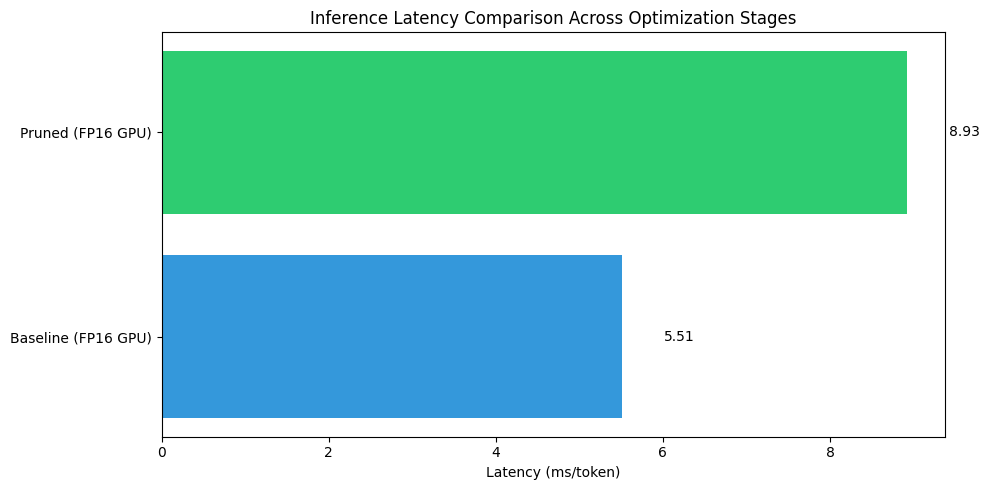

In [29]:
import matplotlib.pyplot as plt

def plot_latency(metrics):
    """
    Plots a horizontal bar chart of latency values from different optimization stages.

    Args:
        metrics (dict): A dictionary containing model stages as keys and dictionaries as values.
                        Each inner dictionary should contain a 'latency' field indicating the
                        latency in milliseconds per token. For example:
                        
                        {
                            "Baseline (FP16 GPU)": {"latency": 12.5, "ppl": 40.03, "vram": 7.5},
                            "Pruned (FP16 GPU)":   {"latency": 10.2, "ppl": 55.54, "vram": 6.0},
                            "Quant (INT8 CPU)":    {"latency": 18.7, "ppl": 51.0,  "ram": 3.2}
                        }

    Returns:
        None. Displays a horizontal bar chart showing latency across optimization stages.

    TODO:
        1. Extract stage names from the metrics dictionary.
        2. Extract corresponding latency values for each stage.
        3. Use `matplotlib.pyplot` to create a horizontal bar chart.
        4. Label the x-axis as "Latency (ms/token)" and give an appropriate chart title.
        5. Annotate each bar with its exact latency value using `plt.text()`.
    """
    # TODO 1: Extract stage names
    stages = list(metrics.keys())
    
    # TODO 2: Extract latency values
    latencies = [metrics[stage]["latency"] for stage in stages]
    
    # TODO 3: Create horizontal bar chart
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.barh(stages, latencies, color=['#3498db', '#2ecc71', '#e74c3c'])
    
    # TODO 4: Label axes and title
    ax.set_xlabel("Latency (ms/token)")
    ax.set_title("Inference Latency Comparison Across Optimization Stages")
    
    # TODO 5: Annotate each bar with its value
    for bar, latency in zip(bars, latencies):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'{latency:.2f}', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

plot_latency(metrics)

### Plot Memory Usage (GPU VRAM vs CPU RAM)

Metrics keys per stage:
  Baseline (FP16 GPU): ['latency', 'ppl', 'vram']
  Pruned (FP16 GPU): ['latency', 'ppl', 'vram']
  Quant (INT8 CPU): ['latency', 'ppl', 'ram']


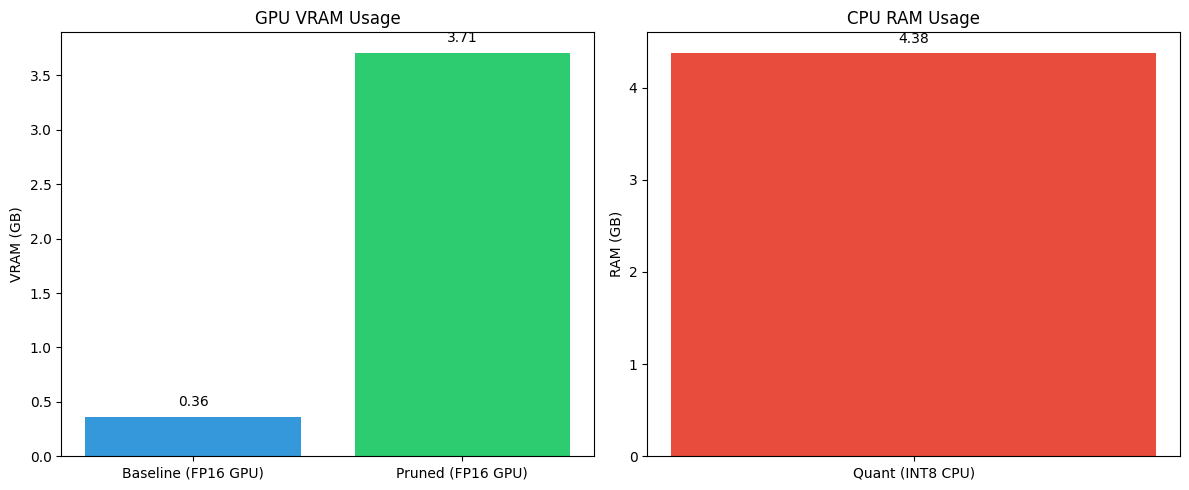

In [30]:
import matplotlib.pyplot as plt

def plot_memory_usage(metrics):
    """
    Plots two separate bar charts:
      1. GPU VRAM usage for all stages that include a 'vram' key.
      2. CPU RAM usage for the stage named 'Quant (INT8 CPU)' which includes a 'ram' key.

    Args:
        metrics (dict): A dictionary of performance metrics per stage. Each key is a stage name,
                        and each value is a dictionary that may include:
                            - 'vram': GPU memory in GB
                            - 'ram':  CPU memory in GB
                            - Other metrics like 'latency', 'ppl', etc.

    Returns:
        None. Displays memory usage bar charts.

    TODO:
        1. Extract and print all stages and their keys for debugging.
        2. Filter out only those stages that include the 'vram' key.
        3. Plot GPU memory (VRAM) usage for those stages.
        4. If the stage "Quant (INT8 CPU)" has a 'ram' key, plot CPU RAM usage.
    """
    # TODO 1: Debug print
    print("Metrics keys per stage:")
    for stage, data in metrics.items():
        print(f"  {stage}: {list(data.keys())}")
    
    # TODO 2: Filter stages that include 'vram'
    gpu_stages = [s for s in metrics if "vram" in metrics[s]]
    gpu_vram = [metrics[s]["vram"] for s in gpu_stages]
    
    # TODO 3: Plot GPU VRAM usage
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].bar(gpu_stages, gpu_vram, color=['#3498db', '#2ecc71'])
    axes[0].set_ylabel("VRAM (GB)")
    axes[0].set_title("GPU VRAM Usage")
    for i, v in enumerate(gpu_vram):
        axes[0].text(i, v + 0.1, f'{v:.2f}', ha='center')
    
    # TODO 4: Plot CPU RAM usage if available
    if "Quant (INT8 CPU)" in metrics and "ram" in metrics["Quant (INT8 CPU)"]:
        cpu_ram = metrics["Quant (INT8 CPU)"]["ram"]
        axes[1].bar(["Quant (INT8 CPU)"], [cpu_ram], color='#e74c3c')
        axes[1].set_ylabel("RAM (GB)")
        axes[1].set_title("CPU RAM Usage")
        axes[1].text(0, cpu_ram + 0.1, f'{cpu_ram:.2f}', ha='center')
    else:
        axes[1].text(0.5, 0.5, "No CPU RAM data", ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title("CPU RAM Usage")
    
    plt.tight_layout()
    plt.show()

plot_memory_usage(metrics)

### Plot Perplexity Comparison

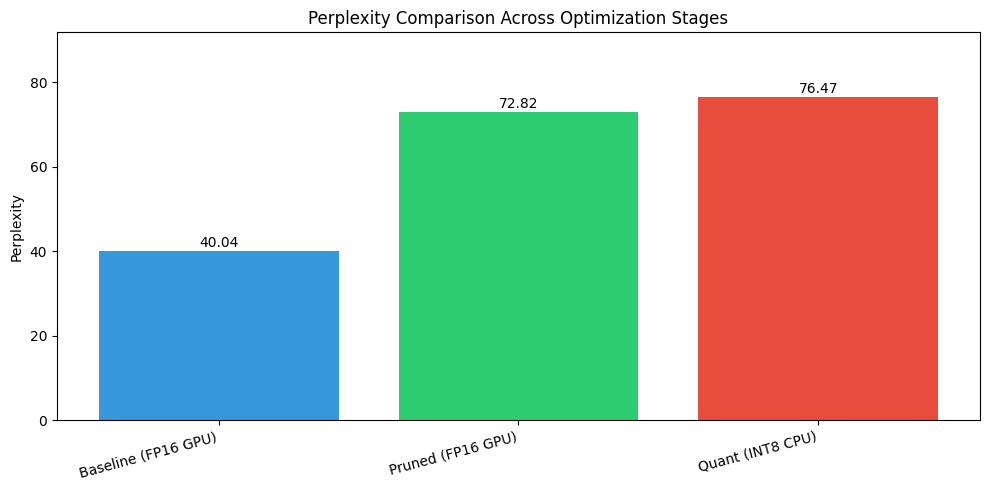

In [31]:
import matplotlib.pyplot as plt

def plot_perplexity(metrics):
    """
    Plots a bar chart showing perplexity values across different model optimization stages.

    Args:
        metrics (dict): A dictionary where keys are stage names and values are dictionaries
                        containing various performance metrics. Each stage dictionary should
                        include a 'ppl' (perplexity) key. For example:

                        {
                            "Baseline (FP16 GPU)": {"latency": 12.5, "ppl": 40.03, "vram": 7.5},
                            "Pruned (FP16 GPU)":   {"latency": 10.2, "ppl": 55.54, "vram": 6.0},
                            "Quant (INT8 CPU)":    {"latency": 18.7, "ppl": 51.0,  "ram": 3.2}
                        }

    Returns:
        None. Displays a bar chart of perplexity values.

    TODO:
        1. Extract stage names from the metrics dictionary.
        2. Extract corresponding perplexity values for each stage.
        3. Use `matplotlib.pyplot` to plot a vertical bar chart.
        4. Annotate each bar with the corresponding perplexity value.
    """
    # TODO 1: Extract stage names
    stages = list(metrics.keys())
    
    # TODO 2: Extract perplexity values
    perplexities = [metrics[stage]["ppl"] for stage in stages]
    
    # TODO 3: Plot bar chart
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.bar(stages, perplexities, color=['#3498db', '#2ecc71', '#e74c3c'])
    
    # TODO 4: Labeling
    ax.set_ylabel("Perplexity")
    ax.set_title("Perplexity Comparison Across Optimization Stages")
    ax.set_ylim(0, max(perplexities) * 1.2)
    
    # Annotate bars
    for bar, ppl in zip(bars, perplexities):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{ppl:.2f}', ha='center', fontsize=10)
    
    plt.xticks(rotation=15, ha='right')
    plt.tight_layout()
    plt.show()

plot_perplexity(metrics)

#### Generate FLAME graphs using Tensorboard

### Run inference on CPU to predict next word

In [32]:
import torch
import torch.nn.functional as F

def get_next_token_suggestions(
    model,
    tokenizer,
    prompt: str,
    top_k: int = 5
):
    """
    Returns the top_k most likely next‐token suggestions for a given prompt.

    Args:
      model (INCModelForCausalLM or HF model): model on CPU
      tokenizer (AutoTokenizer): matching tokenizer
      prompt (str): the input text so far
      top_k (int): how many token suggestions to return

    Returns:
      List of (token_str, probability) tuples, sorted by descending probability.
    """
    model.eval()

    # Ensure tokenizer is properly set for padding
    if tokenizer.pad_token_id is None:
        tokenizer.pad_token_id = tokenizer.eos_token_id
    tokenizer.padding_side = "left"

    # Tokenize the prompt with padding
    inputs = tokenizer(prompt, return_tensors="pt", padding=True)

    # Get model logits (no cache to avoid shape issues)
    with torch.no_grad():
        outputs = model(**inputs, use_cache=False)
        logits = outputs.logits

    # Logits for the last token
    last_token_logits = logits[0, -1, :]

    # Probabilities and top-k
    probs = F.softmax(last_token_logits, dim=-1)
    top_probs, top_indices = torch.topk(probs, top_k)

    # Convert to list of (token_string, probability)
    suggestions = []
    for prob, idx in zip(top_probs.tolist(), top_indices.tolist()):
        token_str = tokenizer.decode([idx])
        suggestions.append((token_str, prob))

    return suggestions


prompt_text = "Chelsea Football Club will win the Champions League and"
try:
    # Try quantized model + its tokenizer
    suggestions = get_next_token_suggestions(
        quant_model_cpu,
        quant_tokenizer_cpu,
        prompt_text,
        top_k=3
    )
except Exception as e:
    print(f"Quantized model failed, falling back to FP16 model: {e}")
    suggestions = get_next_token_suggestions(
        model,
        tokenizer,
        prompt_text,
        top_k=3
    )

print(f"Prompt: {prompt_text!r}\n")
print("Next-word suggestions (token ⟶ probability):")
for token_str, prob in suggestions:
    print(f"  {token_str!r} ⟶ {prob:.4f}")

Quantized model failed, falling back to FP16 model: shape '[1, 9, 768]' is invalid for input of size 5760
Prompt: 'Chelsea Football Club will win the Champions League and'

Next-word suggestions (token ⟶ probability):
  ' the' ⟶ 0.3530
  ' Europa' ⟶ 0.1126
  ' FA' ⟶ 0.0496


In [33]:
# 🔧 Alternative INT8 path: dynamic quantization that supports generation
# This creates a dynamic-quantized GPT-2 (PyTorch native) that works with `generate()` on CPU.
# It uses weight-only int8 for Linear layers; activations remain FP32.

from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

DYN_INT8_DIR = "gpt2_dynamic_int8"

# Load fp32 base on CPU
base_tokenizer = tokenizer  # reuse existing tokenizer
base_model = AutoModelForCausalLM.from_pretrained("gpt2")
base_model.to("cpu")
base_model.eval()
base_model.config.use_cache = False  # disable cache to avoid shape issues

# Dynamic quantization on Linear layers (weight-only int8)
quantized_dyn = torch.quantization.quantize_dynamic(
    base_model,
    {torch.nn.Linear},
    dtype=torch.qint8
)

# NOTE: quantize_dynamic returns a plain nn.Module; saving with save_pretrained hits dtype issues.
# We'll use the quantized model directly without saving.

dyn_int8_model = quantized_dyn
# Ensure tokenizer has pad token
if base_tokenizer.pad_token_id is None:
    base_tokenizer.pad_token_id = base_tokenizer.eos_token_id
base_tokenizer.padding_side = "left"
dyn_int8_tokenizer = base_tokenizer

prompt = "Chelsea Football Club will win the Champions League and"
inputs = dyn_int8_tokenizer(prompt, return_tensors="pt", padding=True)
with torch.no_grad():
    out_ids = dyn_int8_model.generate(
        **inputs,
        max_new_tokens=16,
        do_sample=False,
        pad_token_id=dyn_int8_tokenizer.eos_token_id,
        use_cache=False,
    )
text_out = dyn_int8_tokenizer.decode(out_ids[0], skip_special_tokens=True)
print(text_out)



Chelsea Football Club will win the Champions League and Citizenship Dialogue Management Awards Online Football Method Exam Next Regions Online Opportunibaba Competition Opportuniversal
